# Calculating Regulatory Capital with the ASRF Model

<p style='text-align: justify;'> This example shows how to calculate capital requirements and value-at-risk (VaR) for a credit sensitive portfolio of exposures using the asymptotic single risk factor (ASRF) model. This example also shows how to compute Basel capital requirements using an ASRF model. </p>

## The ASRF Model

<p style='text-align: justify;'> The ASRF model defines capital as the credit value at risk (VaR) in excess of the expected loss (EL).</p>

$$Capital  = VaR -  EL$$

<p style='text-align: justify;'> where the EL for a given counterparty is the exposure at default (EAD) multiplied by the probability of default (PD) and the loss given default (LGD). </p>

$$EL_{i} = PD_{i}*LGD_{i}*EAD_{i}$$

hence, the total expected loss is given by 

$$EL = \sum \limits _{i=1} ^{N} PD_{i}*LGD_{i}*EAD_{i}$$

where $N$ is the total number of enteries in portfolio.

<p style='text-align: justify;'> To compute the credit VaR, the ASRF model assumes that obligor credit quality is modeled with a latent variable (A) using a one factor model where the single common factor (Z) represents systemic credit risk in the market.</p>

$$A_{i} = \sqrt{\rho_{i}} Z + \sqrt{1 - \rho_{i}} \epsilon$$

Under this model, default losses for a particular scenario are calculated as:

$$ L  = I *LGD*EAD$$

<p style='text-align: justify;'> where $I$ is the default indicator, and has a value of 1 if $A_{i} < \Phi^{-1}_{A}(PD_{i})$ (meaning the latent variable has fallen below the threshold for default), and a value of 0 otherwise. The expected value of the default indicator conditional on the common factor is given by: </p>

$$E(I_{i}|Z) =  \Phi_{\epsilon}(\frac{\Phi^{-1}_{A}(PD_{i}) - \sqrt{\rho_{i}} Z}{\sqrt{1 - \rho_{i}}})$$

<p style='text-align: justify;'> For well diversified and perfectly granular portfolios, the expected loss conditional on a value of the common factor is:</p>

$$L|Z = \sum \limits _{i=1} ^{N} EAD_{i}*LGD_{i}* \Phi_{\epsilon}(\frac{\Phi^{-1}_{A}(PD_{i}) - \sqrt{\rho_{i}} Z}{\sqrt{1 - \rho_{i}}})$$

<p style='text-align: justify;'> You can then directly compute particular percentiles of the distribution of losses using the cumulative distribution function of the common factor. This is the credit VaR, which we compute at the α confidence level:</p>

$$capitalVar(\alpha) = \sum \limits _{i=1} ^{N} EAD_{i}*LGD_{i}* \Phi_{\epsilon}(\frac{\Phi^{-1}_{A}(PD_{i}) - \sqrt{\rho_{i}} \Phi^{-1}_{Z}(1 - \alpha)}{\sqrt{1 - \rho_{i}}})$$

It follows that the capital for a given level of confidence, α, is:

$$capital(\alpha) = \sum \limits _{i=1} ^{N} EAD_{i}*LGD_{i}* (\Phi_{\epsilon}(\frac{\Phi^{-1}_{A}(PD_{i}) - \sqrt{\rho_{i}} \Phi^{-1}_{Z}(1 - \alpha)}{\sqrt{1 - \rho_{i}}}) - PD_{i})$$

# Importing required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; #sns.set(font_scale = 0.8)
sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})

In [2]:
import warnings
warnings.filterwarnings("ignore")
from IPython.core.display import display, HTML

# Loading the dataset
<p style='text-align: justify;'> The portfolio contains 100 credit sensitive contracts and information about their exposure. This is simulated data.  </p>

In [3]:
portfolio = pd.read_csv('Portfolio.csv', delimiter = ',')
portfolio['Settle'] = '13-Jul-2017'                     # Settelment data

In [4]:
# Displaying head and tail of a given dataset together
display(pd.concat([portfolio.head(),  portfolio.tail()]))

,ID,EAD,PD,LGD,AssetClass,Sales,Maturity,Settle
0,1,294502.039952,0.013644,0.50,Bank,NaN,02-Jun-2023,13-Jul-2017
1,2,133488.552043,0.001752,0.50,Bank,NaN,05-Jul-2021,13-Jul-2017
2,3,317229.156608,0.016940,0.40,Bank,NaN,07-Oct-2018,13-Jul-2017
3,4,287194.469569,0.013624,0.35,Bank,NaN,27-Apr-2022,13-Jul-2017
4,5,299646.413525,0.013191,0.45,Bank,NaN,07-Dec-2022,13-Jul-2017
95,96,197083.545529,0.013086,0.40,Unregulated Financial,NaN,27-Feb-2020,13-Jul-2017
96,97,331475.399127,0.019671,0.45,Unregulated Financial,NaN,04-Mar-2022,13-Jul-2017
97,98,242568.552438,0.020183,0.50,Unregulated Financial,NaN,09-Nov-2020,13-Jul-2017
98,99,329178.652989,0.005944,0.35,Unregulated Financial,NaN,17-Oct-2019,13-Jul-2017
99,100,275566.060205,0.026568,0.65,Unregulated Financial,NaN,27-Oct-2019,13-Jul-2017


# Explatory analysis of a given predictors

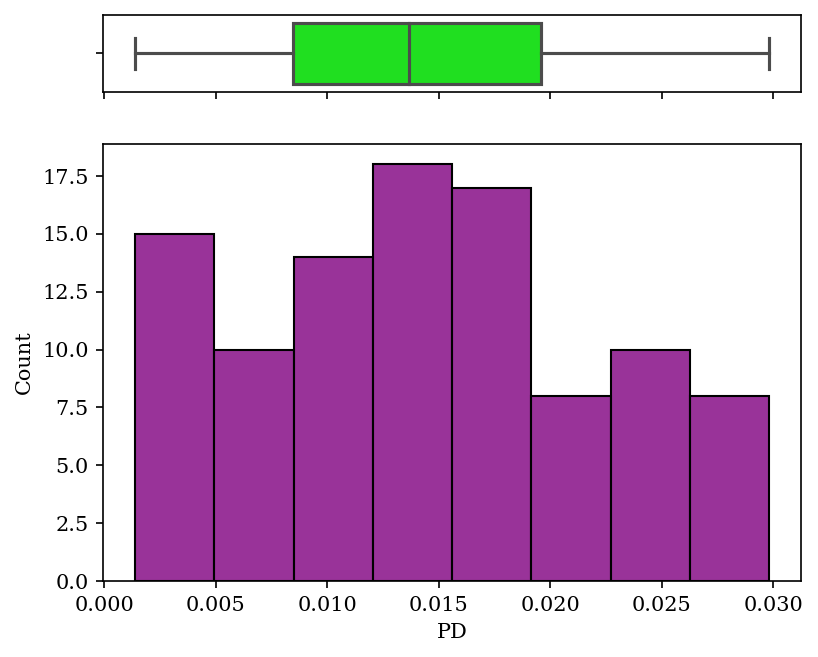

In [5]:
# The probability of default (PD) will be the first predictors which is subjected to the 
# explatory analysis. In order to get a general and basic statistical information, in addition
# to its histogram, drawing its box plot in the same panel would gives more information. To this
# end, in the below, the histogram and box plot of  of PD ig shown.

# creating a figure composed of two matplotlib.Axes objects (ax_box and ax_hist)
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, \
                       gridspec_kw={"height_ratios": (.15, .85)}, figsize = (6, 5), dpi = 150)
 
# assigning a graph to each ax
sns.boxplot(portfolio["PD"], ax = ax_box , color = 'lime', )
sns.histplot(data = portfolio, x = "PD", ax = ax_hist, color = 'purple', alpha = 0.8)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel = '')
plt.show()

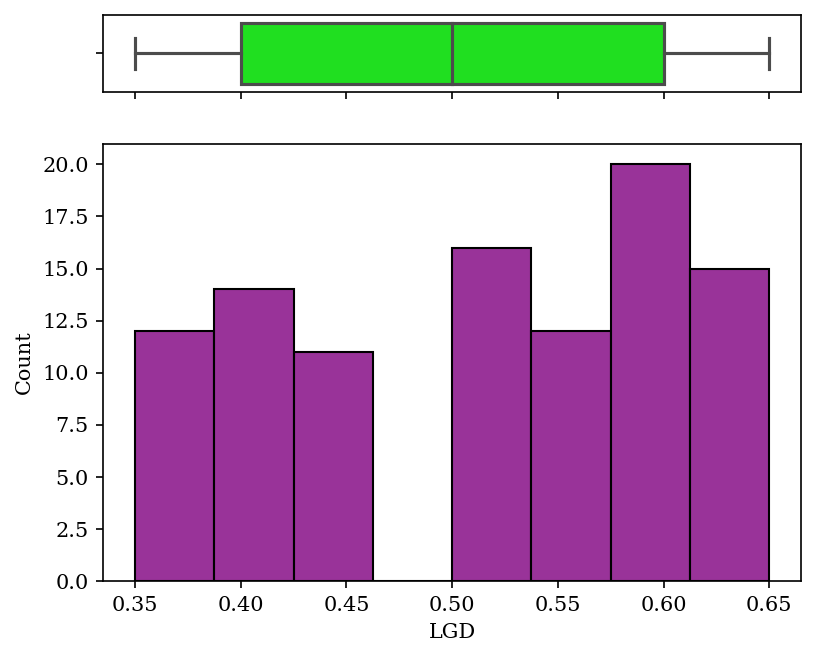

In [6]:
# As discussed above, combination of the box plot with histogram will transfer more
# statistical basic information regarding the predictor under study. Hence, the same
# procedure will be applied for the LGD as well.

# creating a figure composed of two matplotlib.Axes objects (ax_box and ax_hist)
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, \
                       gridspec_kw={"height_ratios": (.15, .85)}, figsize = (6, 5), dpi = 150)
 
# assigning a graph to each ax
sns.boxplot(portfolio["LGD"], ax = ax_box , color = 'lime', )
sns.histplot(data = portfolio, x = "LGD", ax = ax_hist, color = 'purple', alpha = 0.8)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel = '')
plt.show()

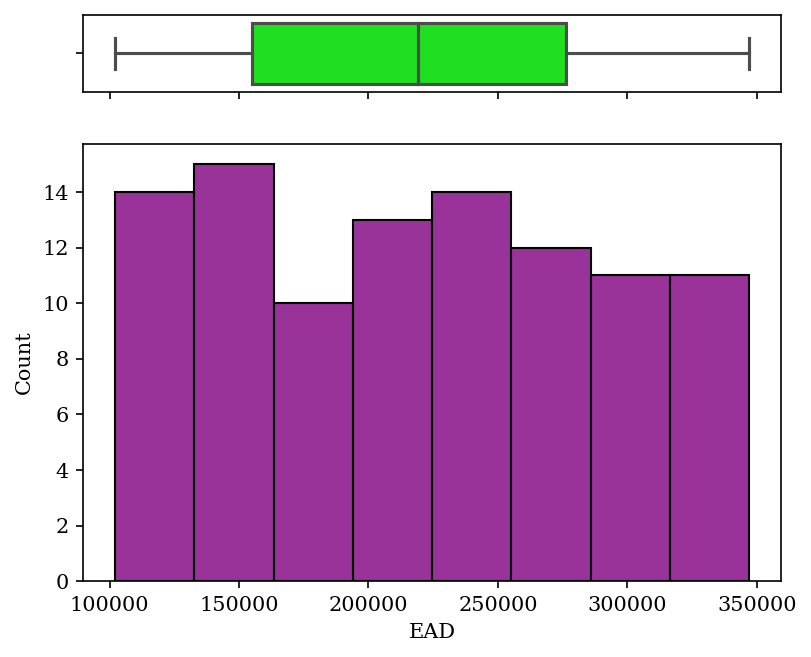

In [7]:
# As discussed above, combination of the box plot with histogram will transfer more
# statistical basic information regarding the predictor under study. Hence, the same
# procedure will be applied for the LGD as well.

# creating a figure composed of two matplotlib.Axes objects (ax_box and ax_hist)
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, \
                       gridspec_kw={"height_ratios": (.15, .85)}, figsize = (6, 5), dpi = 150)
 
# assigning a graph to each ax
sns.boxplot(portfolio["EAD"], ax = ax_box , color = 'lime', )
sns.histplot(data = portfolio, x = "EAD", ax = ax_hist, color = 'purple', alpha = 0.8)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel = '')
plt.show()

# Comparing the EAD and its non-recoverable part vs the type of credit

In [8]:
Loss         = portfolio[['EAD', 'LGD', 'AssetClass']]
Loss['EAD.LGD'] = Loss['EAD']* Loss['LGD' ]
Loss

Loss_group = Loss.groupby(['AssetClass']).sum().reset_index()
Loss_group

,AssetClass,EAD,LGD,EAD.LGD
0,Bank,3.421707e+06,7.20,1.728864e+06
1,Corporate,3.674009e+06,9.85,1.911602e+06
2,Medium Entity,2.977055e+06,6.55,1.533946e+06
3,Small Entity,1.736822e+06,5.00,8.954868e+05
4,Sovereign,6.412478e+06,14.50,3.391226e+06
5,Unregulated Financial,3.637315e+06,8.00,1.839663e+06


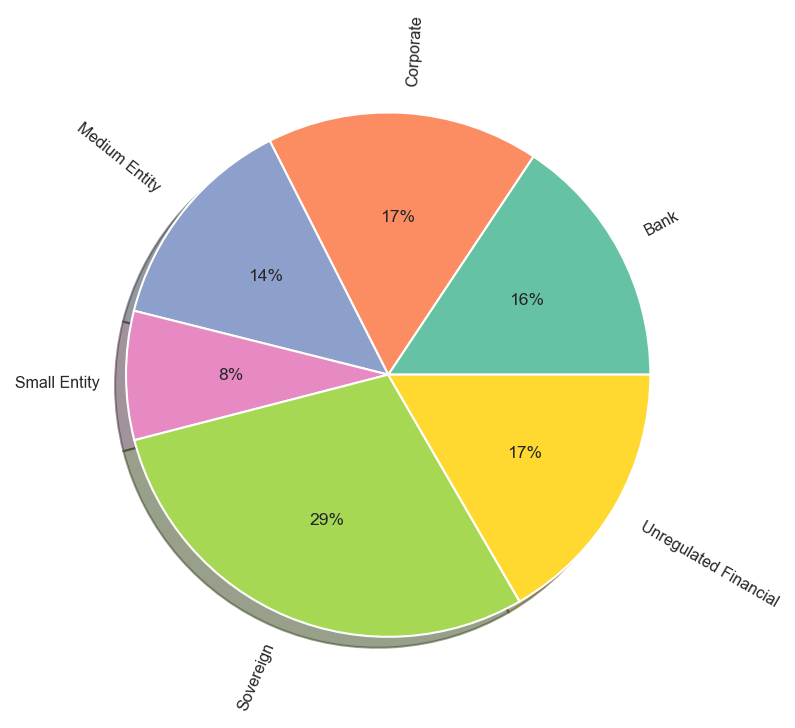

In [9]:
# In order to see the contibution of the different types of the credit into
# exposure at total default, the pi-chart is shown in below. As is shown, the
# sovergien loans has the highest contribution to the toal EAD.

fig, ax = plt.subplots(figsize = (6, 5), dpi = 150)
sns.set(rc = {'figure.figsize':(14,10)}, font_scale = 0.7)


# Seaborn color palette to plot pie chart
colors = sns.color_palette('Set2')

# # create pie chart using matplotlib
ax.pie(Loss_group['EAD'], labels = Loss_group['AssetClass'], colors = colors,
                     autopct='%.0f%%', shadow = True, rotatelabels = 'true')

plt.tight_layout()
plt.show()

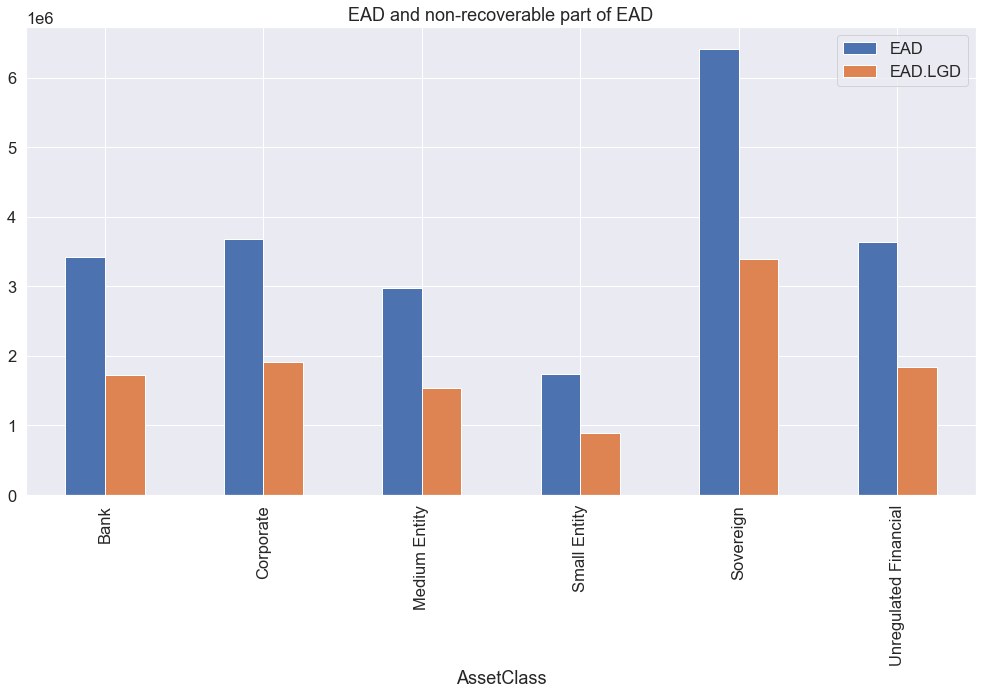

In [10]:
# In order to compare the EAD when default happend and the actual value lost corresponding
# to a default, the below bar chart is shown.

sns.set(rc = {'figure.figsize':(14,10)}, font_scale = 1.5)

Loss_group.plot(x = 'AssetClass', y = ["EAD", "EAD.LGD"], kind = "bar", )

plt.title("EAD and non-recoverable part of EAD")
plt.xlabel("AssetClass")

plt.tight_layout()
plt.show()

# Expected loss estimation

In [11]:
portfolio['Elosss'] = portfolio['PD']*portfolio['LGD']*portfolio['EAD']

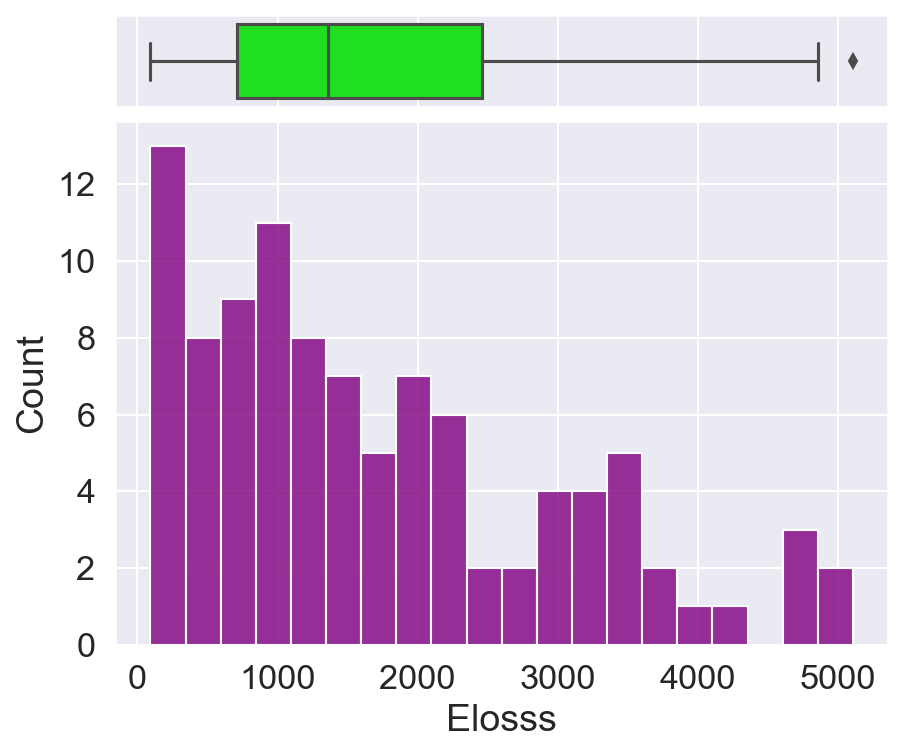

In [12]:
# creating a figure composed of two matplotlib.Axes objects (ax_box and ax_hist)
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, \
                       gridspec_kw={"height_ratios": (.15, .85)}, figsize = (6, 5), dpi = 150)
sns.set(rc = {'figure.figsize':(14,10)}, font_scale = 0.5)


 
# assigning a graph to each ax
sns.boxplot(portfolio["Elosss"], ax = ax_box , color = 'lime', )
sns.histplot(data = portfolio, x = "Elosss", ax = ax_hist, color = 'purple', alpha = 0.8, bins = 20)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel  = '')
plt.tight_layout()
plt.show()

# Risk weight function 

<p style='text-align: justify;'> This part presents the calculation of risk weighted assets under the internal ratings-based (IRB) approach for: (i) corporate, sovereign and bank exposures; and (ii) retail exposures. Risk weighted assets are designed to address unexpected losses from exposures. More detailed information can be found 
    <a href="https://www.bis.org/basel_framework/chapter/CRE/31.htm?tldate=20191216&inforce=20220101&published=20191215">here.</a></p>

In [13]:
# Compute the correlations for corporate, sovereign, and bank exposures.

def corporate_sovereign_bank(PD):
    import numpy as np
    R = 0.12 * (1 - np.exp(-50*PD))/(1 - np.exp(-50)) + \
        0.24 * (1 - (1-np.exp(-50*PD))/(1-np.exp(-50)))
    return R

In [14]:
# Compute the correlations for small and medium entities.

def Small_Entity_Medium_Entity(PD, Sales):
    import numpy as np
    R = 0.12 * (1-np.exp(-50*PD)) / (1-np.exp(-50)) + \
    0.24 * (1 - (1 - np.exp(-50*PD)) / (1 - np.exp(-50))) - \
    0.04 * (1 - (Sales/1e6 - 5) / 45);
    return R

In [15]:
# Compute the correlations for unregulated financial institutions.

def Unregulated_Financial(PD):
    import numpy as np
    R = 1.25 * (0.12 * (1 - np.exp(-50*PD)) / (1 - np.exp(-50)) +\
        0.24 * (1 - (1 - np.exp(-50*PD)) / (1 - np.exp(-50))))
    return R

<p style='text-align: justify;'> Find the basic ASRF capital using the Basel-defined asset correlations. The default value for the VaR level is 99.9%.  </p>

In [16]:
m, n = portfolio.shape
portfolio['Rho']   = 0

for i in range(m):
    #print(i)
    x  = portfolio.iloc[i,:]
    #print(x)
    if ((x['AssetClass'] == 'Corporate') | (x['AssetClass'] == 'Sovereign') | (x['AssetClass'] == 'Bank')):
        rho = corporate_sovereign_bank(x['PD'])
        portfolio.iloc[i, n] = rho 
    elif ((x['AssetClass'] == 'Small Entity') | (x['AssetClass'] == 'Medium Entity')):
        rho = Small_Entity_Medium_Entity(x['PD'], x['Sales'])
        #print(rho)
        portfolio.iloc[i, n] = rho 
    elif ((x['AssetClass'] == 'Unregulated Financial')):
        rho = Unregulated_Financial(x['PD'])
        portfolio.iloc[i, n] = rho     

In [17]:
portfolio.head()

,ID,EAD,PD,LGD,AssetClass,Sales,Maturity,Settle,Elosss,Rho
0,1,294502.039952,0.013644,0.50,Bank,NaN,02-Jun-2023,13-Jul-2017,2009.071147,0.180661
1,2,133488.552043,0.001752,0.50,Bank,NaN,05-Jul-2021,13-Jul-2017,116.926676,0.229936
2,3,317229.156608,0.016940,0.40,Bank,NaN,07-Oct-2018,13-Jul-2017,2149.571648,0.171443
3,4,287194.469569,0.013624,0.35,Bank,NaN,27-Apr-2022,13-Jul-2017,1369.493228,0.180720
4,5,299646.413525,0.013191,0.45,Bank,NaN,07-Dec-2022,13-Jul-2017,1778.641127,0.182051


In [18]:
from scipy.stats import norm

VaRLevel = 0.999


m, n = portfolio.shape
portfolio['VaR']   = 0

for i in range(m):
    #print(i)
    x  = portfolio.iloc[i,:]    
    x1 = (norm.ppf(x['PD']) - np.sqrt(x['Rho'])*norm.ppf(1 - VaRLevel))/(np.sqrt(1 - x['Rho']))
    portfolio.iloc[i, n] = x['EAD']*x['LGD']*norm.cdf(x1) -  x['EAD']*x['LGD']*x['PD']

In [19]:
portfolio

,ID,EAD,PD,LGD,AssetClass,Sales,Maturity,Settle,Elosss,Rho,VaR
0,1,294502.039952,0.013644,0.50,Bank,NaN,02-Jun-2023,13-Jul-2017,2009.071147,0.180661,21799.672879
1,2,133488.552043,0.001752,0.50,Bank,NaN,05-Jul-2021,13-Jul-2017,116.926676,0.229936,3263.920910
2,3,317229.156608,0.016940,0.40,Bank,NaN,07-Oct-2018,13-Jul-2017,2149.571648,0.171443,20372.368160
3,4,287194.469569,0.013624,0.35,Bank,NaN,27-Apr-2022,13-Jul-2017,1369.493228,0.180720,14872.850740
4,5,299646.413525,0.013191,0.45,Bank,NaN,07-Dec-2022,13-Jul-2017,1778.641127,0.182051,19700.429514
...,...,...,...,...,...,...,...,...,...,...,...
95,96,197083.545529,0.013086,0.40,Unregulated Financial,NaN,27-Feb-2020,13-Jul-2017,1031.602267,0.227971,14517.727686
96,97,331475.399127,0.019671,0.45,Unregulated Financial,NaN,04-Mar-2022,13-Jul-2017,2934.265725,0.206096,31405.796703
97,98,242568.552438,0.020183,0.50,Unregulated Financial,NaN,09-Nov-2020,13-Jul-2017,2447.875511,0.204679,25737.086806
98,99,329178.652989,0.005944,0.35,Unregulated Financial,NaN,17-Oct-2019,13-Jul-2017,684.804475,0.261435,15237.629351


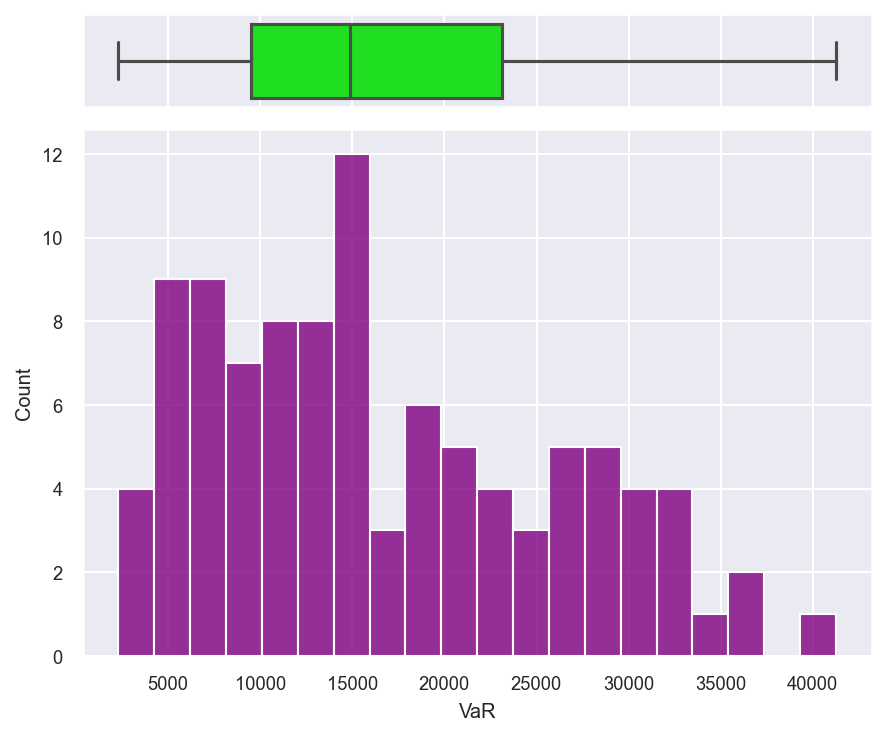

In [39]:
# creating a figure composed of two matplotlib.Axes objects (ax_box and ax_hist)
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, \
                       gridspec_kw={"height_ratios": (.15, .85)}, figsize = (6, 5), dpi = 150)
sns.set(rc = {'figure.figsize':(14,10)}, font_scale = 0.8)


# assigning a graph to each ax
sns.boxplot(portfolio["VaR"], ax = ax_box , color = 'lime', )
sns.histplot(data = portfolio, x = "VaR", ax = ax_hist, color = 'purple', alpha = 0.8, bins = 20)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel  = '')
plt.tight_layout()
plt.show()

In [21]:
portfolio['Capital'] = portfolio['VaR']
portfolio

,ID,EAD,PD,LGD,AssetClass,Sales,Maturity,Settle,Elosss,Rho,VaR,Capital
0,1,294502.039952,0.013644,0.50,Bank,NaN,02-Jun-2023,13-Jul-2017,2009.071147,0.180661,21799.672879,21799.672879
1,2,133488.552043,0.001752,0.50,Bank,NaN,05-Jul-2021,13-Jul-2017,116.926676,0.229936,3263.920910,3263.920910
2,3,317229.156608,0.016940,0.40,Bank,NaN,07-Oct-2018,13-Jul-2017,2149.571648,0.171443,20372.368160,20372.368160
3,4,287194.469569,0.013624,0.35,Bank,NaN,27-Apr-2022,13-Jul-2017,1369.493228,0.180720,14872.850740,14872.850740
4,5,299646.413525,0.013191,0.45,Bank,NaN,07-Dec-2022,13-Jul-2017,1778.641127,0.182051,19700.429514,19700.429514
...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,197083.545529,0.013086,0.40,Unregulated Financial,NaN,27-Feb-2020,13-Jul-2017,1031.602267,0.227971,14517.727686,14517.727686
96,97,331475.399127,0.019671,0.45,Unregulated Financial,NaN,04-Mar-2022,13-Jul-2017,2934.265725,0.206096,31405.796703,31405.796703
97,98,242568.552438,0.020183,0.50,Unregulated Financial,NaN,09-Nov-2020,13-Jul-2017,2447.875511,0.204679,25737.086806,25737.086806
98,99,329178.652989,0.005944,0.35,Unregulated Financial,NaN,17-Oct-2019,13-Jul-2017,684.804475,0.261435,15237.629351,15237.629351


# Maturity adjustment

In [22]:
from datetime import timedelta

In [23]:
from scipy.stats import norm

m, n = portfolio.shape
portfolio['maturityYears']   = 0

for i in range(m):
    #print(i)
    x  = portfolio.iloc[i,:]    
    portfolio.iloc[i, n] = ((pd.to_datetime(x['Maturity'], format = "%d-%b-%Y") - pd.to_datetime(x['Settle']  , format = "%d-%b-%Y"))/(np.timedelta64(1,'Y')))

In [24]:
portfolio

,ID,EAD,PD,LGD,AssetClass,Sales,Maturity,Settle,Elosss,Rho,VaR,Capital,maturityYears
0,1,294502.039952,0.013644,0.50,Bank,NaN,02-Jun-2023,13-Jul-2017,2009.071147,0.180661,21799.672879,21799.672879,5.886500
1,2,133488.552043,0.001752,0.50,Bank,NaN,05-Jul-2021,13-Jul-2017,116.926676,0.229936,3263.920910,3263.920910,3.978179
2,3,317229.156608,0.016940,0.40,Bank,NaN,07-Oct-2018,13-Jul-2017,2149.571648,0.171443,20372.368160,20372.368160,1.234796
3,4,287194.469569,0.013624,0.35,Bank,NaN,27-Apr-2022,13-Jul-2017,1369.493228,0.180720,14872.850740,14872.850740,4.788599
4,5,299646.413525,0.013191,0.45,Bank,NaN,07-Dec-2022,13-Jul-2017,1778.641127,0.182051,19700.429514,19700.429514,5.401891
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,197083.545529,0.013086,0.40,Unregulated Financial,NaN,27-Feb-2020,13-Jul-2017,1031.602267,0.227971,14517.727686,14517.727686,2.625653
96,97,331475.399127,0.019671,0.45,Unregulated Financial,NaN,04-Mar-2022,13-Jul-2017,2934.265725,0.206096,31405.796703,31405.796703,4.640752
97,98,242568.552438,0.020183,0.50,Unregulated Financial,NaN,09-Nov-2020,13-Jul-2017,2447.875511,0.204679,25737.086806,25737.086806,3.326557
98,99,329178.652989,0.005944,0.35,Unregulated Financial,NaN,17-Oct-2019,13-Jul-2017,684.804475,0.261435,15237.629351,15237.629351,2.261511


In [25]:
from scipy.stats import norm

m, n = portfolio.shape
portfolio['maturityAdj']   = 0

for i in range(m):
    #print(i)
    x  = portfolio.iloc[i,:]  
    b = (0.11852 - 0.05478 * np.log(x['PD']))*(0.11852 - 0.05478 * np.log(x['PD']));
    portfolio.iloc[i, n ] = (1 + (x['maturityYears'] - 2.5) * b)/ (1 - 1.5 * b)

In [26]:
portfolio.head()

,ID,EAD,PD,LGD,AssetClass,Sales,Maturity,Settle,Elosss,Rho,VaR,Capital,maturityYears,maturityAdj
0,1,294502.039952,0.013644,0.50,Bank,NaN,02-Jun-2023,13-Jul-2017,2009.071147,0.180661,21799.672879,21799.672879,5.886500,1.752908
1,2,133488.552043,0.001752,0.50,Bank,NaN,05-Jul-2021,13-Jul-2017,116.926676,0.229936,3263.920910,3263.920910,3.978179,1.960461
2,3,317229.156608,0.016940,0.40,Bank,NaN,07-Oct-2018,13-Jul-2017,2149.571648,0.171443,20372.368160,20372.368160,1.234796,1.033286
3,4,287194.469569,0.013624,0.35,Bank,NaN,27-Apr-2022,13-Jul-2017,1369.493228,0.180720,14872.850740,14872.850740,4.788599,1.584063
4,5,299646.413525,0.013191,0.45,Bank,NaN,07-Dec-2022,13-Jul-2017,1778.641127,0.182051,19700.429514,19700.429514,5.401891,1.687019


In [27]:
m, n = portfolio.shape
portfolio['regulatoryCapital']   = 0

for i in range(m):
    #print(i)
    x  = portfolio.iloc[i,:]  
    portfolio.iloc[i, n ] = x['Capital']*x['maturityAdj']

In [28]:
portfolio

,ID,EAD,PD,LGD,AssetClass,Sales,Maturity,Settle,Elosss,Rho,VaR,Capital,maturityYears,maturityAdj,regulatoryCapital
0,1,294502.039952,0.013644,0.50,Bank,NaN,02-Jun-2023,13-Jul-2017,2009.071147,0.180661,21799.672879,21799.672879,5.886500,1.752908,38212.824511
1,2,133488.552043,0.001752,0.50,Bank,NaN,05-Jul-2021,13-Jul-2017,116.926676,0.229936,3263.920910,3263.920910,3.978179,1.960461,6398.790051
2,3,317229.156608,0.016940,0.40,Bank,NaN,07-Oct-2018,13-Jul-2017,2149.571648,0.171443,20372.368160,20372.368160,1.234796,1.033286,21050.490309
3,4,287194.469569,0.013624,0.35,Bank,NaN,27-Apr-2022,13-Jul-2017,1369.493228,0.180720,14872.850740,14872.850740,4.788599,1.584063,23559.531044
4,5,299646.413525,0.013191,0.45,Bank,NaN,07-Dec-2022,13-Jul-2017,1778.641127,0.182051,19700.429514,19700.429514,5.401891,1.687019,33235.001057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,197083.545529,0.013086,0.40,Unregulated Financial,NaN,27-Feb-2020,13-Jul-2017,1031.602267,0.227971,14517.727686,14517.727686,2.625653,1.254492,18212.374546
96,97,331475.399127,0.019671,0.45,Unregulated Financial,NaN,04-Mar-2022,13-Jul-2017,2934.265725,0.206096,31405.796703,31405.796703,4.640752,1.486815,46694.604376
97,98,242568.552438,0.020183,0.50,Unregulated Financial,NaN,09-Nov-2020,13-Jul-2017,2447.875511,0.204679,25737.086806,25737.086806,3.326557,1.307954,33662.937246
98,99,329178.652989,0.005944,0.35,Unregulated Financial,NaN,17-Oct-2019,13-Jul-2017,684.804475,0.261435,15237.629351,15237.629351,2.261511,1.264342,19265.578770


In [35]:
print('Portfolio Regulatory Capital : {:.2f} $\n'.format(portfolio['regulatoryCapital'].sum()))

Portfolio Regulatory Capital : 2371316.24 $



Risk weighted assets (RWA) are calculated as capital * 12.5.

In [30]:
m, n = portfolio.shape
portfolio['RWA']   = 0

for i in range(m):
    #print(i)
    x  = portfolio.iloc[i,:]  
    portfolio.iloc[i, n ] = 12.5*x['regulatoryCapital']

In [31]:
portfolio['capital'] = 0.08*portfolio['RWA']

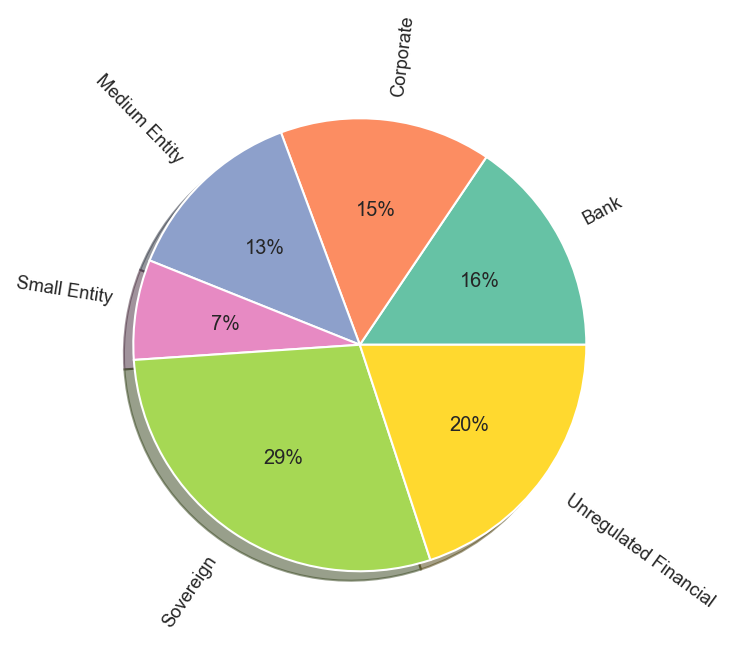

In [37]:
VaR_group = portfolio.groupby(['AssetClass']).sum().reset_index()
VaR_group

# create figure and axes
fig, ax = plt.subplots(figsize = (6, 5), dpi = 150)
sns.set(rc = {'figure.figsize':(14,10)}, font_scale = 0.8)

# Seaborn color palette to plot pie chart
colors = sns.color_palette('Set2')

# create pie chart using matplotlib
plt.pie(VaR_group['RWA'], labels = VaR_group['AssetClass'], colors = colors,
        autopct = '%.0f%%',    shadow = True, rotatelabels = 'true')
plt.show()

# Comparing the results with the MATLAB results. 

More detailed information can be found 
    <a href="https://nl.mathworks.com/help/risk/asrf-model-capital.html">here.</a>

In [41]:
capital_table = VaR_group[['AssetClass','PD', 'LGD', 'EAD', 'Rho', 'VaR', 'RWA', 'capital']]
capital_table.set_index('AssetClass')

,PD,LGD,EAD,Rho,VaR,RWA,capital
AssetClass,,,,,,,
Bank,0.170207,7.20,3.421707e+06,2.625798,243575.507990,4.611742e+06,368939.327359
Corporate,0.230013,9.85,3.674009e+06,3.610067,254871.269417,4.476386e+06,358110.876981
Medium Entity,0.224766,6.55,2.977055e+06,1.989746,224780.892642,3.933226e+06,314658.093784
Small Entity,0.154409,5.00,1.736822e+06,1.636464,120417.975515,2.116219e+06,169297.532269
Sovereign,0.417146,14.50,6.412478e+06,5.101308,483596.151198,8.588902e+06,687112.192914
Unregulated Financial,0.237540,8.00,3.637315e+06,3.626753,343004.858362,5.914978e+06,473198.220085
